# Example2: Localization for single events

In this notebook I will show how to localize a GW event with seal.

In [2]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json
from pycbc.filter import matched_filter,matched_filter_core
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from lal import LIGOTimeGPS

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Case I: Localizing SPIIR trigger events

Seal is going to be implemented in SPIIR, here I show how to process .xml file from SPIIR and localize it.

### Extract information and do it manually

You can extract event information from xml file and provide it to Seal manually. Same function can be used for your own GW events.


In [2]:
# Initialize Seal

seal_O2 = seal.Seal('example_outputs/sealconfig_O2_lhv_BNS.txt') # use the config we fit in example1
xml_filepath = 'example_inputs/H1L1V1_1187008882_3_806.xml'

# extract_info_from_xml returns a lot of useful data that seal needs
# return_names==True: return det names
# return_names==False: return det codes
#  Note here snr_arrays, time_arrays are 1-D arrays, SNR series and timestamps from different detectors are connected to 1-D. 
#  ntimes_array stores the length of each detector, i.e., 
#  the first ntimes_array[0] elements in snr_arrays, is the snr series of 1st detector. Same for timestamps.
#  from ntimes_array[0]+1 to ntimes_array[0]+ntimes_array[1] are elements for 2nd detector.
#  Seal.localize take 1-D array, here is auto-converted when reading xml file. But if you are using your own SNR, remember to convert.
#  See simulation examples below.
trigger_time, ndet, ntimes_array, det_names, max_snr_array, sigma_array, time_arrays, snr_arrays =\
        sealcal.localization.extract_info_from_xml(xml_filepath, return_names=True)

#can be converted with:
#det_codes_array = sealcal.localization.get_det_code_array(det_names)

xml processing done. 
Trigger time: 1187008882.4453125
Detectors: ['H1', 'L1', 'V1']
SNRs: [15.10651112 24.52303505  1.96168923]
sigmas: [1969.1236365  1677.65263077  912.23831788]


In [3]:
########### Reload some event info because xml has some errors ###########
trigger_time = 1187008882.43
start_time = trigger_time-0.01
end_time = trigger_time+0.01
sigma_array = np.array([142*8.0,213*8.0,60*8.0])
print("Time prior and horizon are manually corrected.")
########### Delete above when xml issues are fixed ###########

Time prior and horizon are manually corrected.


In [4]:
# localize with seal. If you set timecost=False, it doesn't return timecost.

nthread = 8 # use 8 threads
max_snr = sum(snr**2 for snr in max_snr_array)
max_snr = max_snr**0.5
logprob_skymap, timecost = seal_O2.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True)

print("Timecost (s): ", timecost)

Timecost (s):  0.49745798110961914


Skymap saved to example_outputs/skymap_GW170817test.pdf


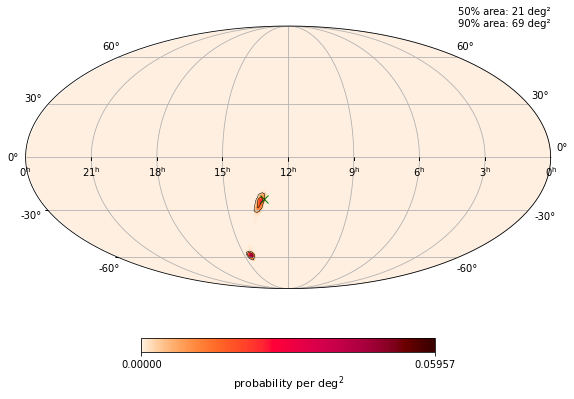

In [5]:
# plot it.
save_filename = 'example_outputs/skymap_GW170817test.pdf'
true_ra = 3.446
true_dec = -0.408
sealcal.localization.plot_skymap(logprob_skymap, save_filename=save_filename, true_ra = true_ra, true_dec = true_dec)

### Let seal do it automatically

The above process can be done by seal. It's convenient to let seal do this inside, but you cannot see what info is stored in xml.

...waiting to fix trigger time and sigma issue in xml...

## Case II: Localizing your simulation events

Seal provides snr_generator to help you generate SNR timeseries (in the format of pycbc timeseries) and sigmas. 

You just need to provide detector, waveform generator, injection parameter (in bilby style), call the snr_generator, and pass the variables. You may need to reshape some variables before passing.

In [16]:
injection_parameters = dict(mass_1 = 1.4, mass_2 = 1.4, chi_1=0.02, chi_2=0.01, lambda_1=425, lambda_2=425,
                            luminosity_distance=200., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=3.1, dec=1.2)

#injection_parameters = dict(mass_1 = 2.783163/2, mass_2 = 2.783163/2, chi_1=0.023, chi_2=0.027, lambda_1=425, lambda_2=425,
#                            luminosity_distance=40., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=3.446, dec=-0.408)

duration = 320. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='TaylorF2', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

'''
for i in range(len(ifos)):
    det = ifos[i]
    #psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 
'''
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



22:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
22:34 bilby INFO    : Injected signal in H1:
22:34 bilby INFO    :   optimal SNR = 7.09
22:34 bilby INFO    :   matched filter SNR = 6.69+0.54j
22:34 bilby INFO    :   mass_1 = 1.4
22:34 bilby INFO    :   mass_2 = 1.4
22:34 bilby INFO    :   chi_1 = 0.02
22:34 bilby INFO    :   chi_2 = 0.01
22:34 bilby INFO    :   lambda_1 = 425
22:34 bilby INFO    :   lambda_2 = 425
22:34 bilby INFO    :   luminosity_distance = 200.0
22:34 bilby INFO    :   theta_jn = 0.4
22:34 bilby INFO    :   psi = 2.6
22:34 bilby INFO    :   phase = 1.3
22:34 bilby INFO    :   geocent_time = 1126259642.4
22:34 bilby INFO    :   ra = 3.1
22:34 bilby INFO    :   dec = 1.2
22:34 bilby INFO    : Injected signal in L1:
22:34 bilby INFO    :   optimal SNR = 5.12
22:34 bilby 

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.05290223e-27-5.82502777e-26j, -2.04985990e-27-5.82502811e-26j,
         -2.04681760e-27-5.82502842e-26j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -5.80538982e-26+2.04598127e-27j, -5.80539015e-26+2.04294919e-27j,
         -5.80539046e-26+2.03991715e-27j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.05290223e-27-5.82502777e-26j, -2.04985990e-27-5.82502811e-26j,
         -2.04681760e-27-5.82502842e-26j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -5.80538982e-26+2.04598127e-27j, -5.80539015e-26+2.04294919e-27j,
         -5.80539046e-26+2.03991715e-27j])},


In [17]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3907228, SNR = 6.851231535057142


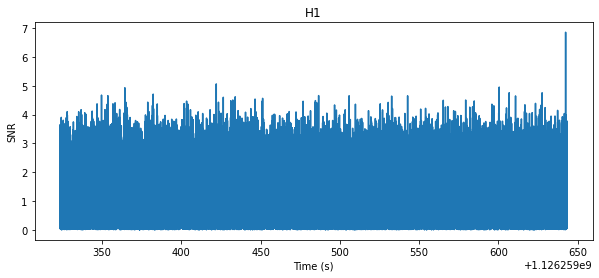

Max snr time: 1126259423.6839356, SNR = 5.445176156056125


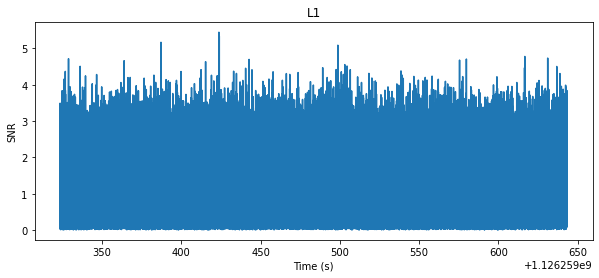

Max snr time: 1126259642.3812013, SNR = 10.487915889968923


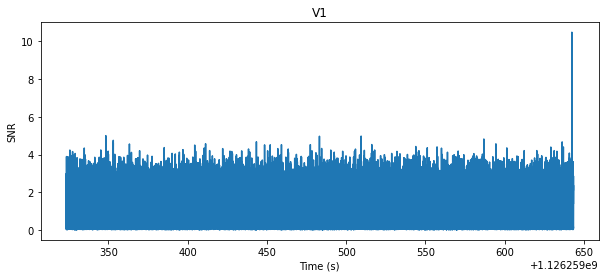

Max network SNR:  13.659637500040263


In [18]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [19]:

nthread = 8 # use 8 threads

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_BNS.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True)

print("Timecost (s): ", timecost)

Timecost (s):  0.7687098979949951


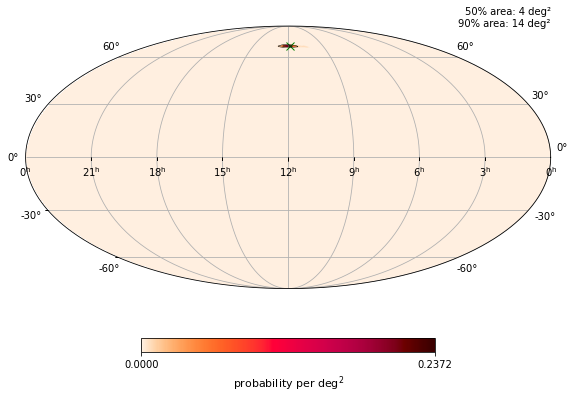

In [20]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [21]:
sealcal.localization.catalog_test_statistics(logprob_skymap, true_ra, true_dec)

(array([ 3.59322592, 13.78277533]), 1.7048152168351824, 0.28827505960608674)

In [52]:
import astropy_healpix as ah
from ligo.skymap import postprocess
from astropy import units as u
import healpy as hp


In [53]:
prob_skymap = np.exp(logprob_skymap)
prob_skymap = prob_skymap/sum(prob_skymap)

In [55]:
cls.min()

0.28386411401397826

In [56]:
nside = ah.npix_to_nside(len(prob_skymap))
deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)

In [64]:
hp?

Object `hp` not found.


In [67]:
theta = np.pi/2 - true_dec
phi = true_ra

pixel_index = hp.pixelfunc.ang2pix(nside, theta, phi, nest=True)

In [68]:
pixel_index

1450470

In [69]:
np.searchsorted?

Signature: np.searchsorted(a, v, side='left', sorter=None)
Docstring:
Find indices where elements should be inserted to maintain order.

Find the indices into a sorted array `a` such that, if the
corresponding elements in `v` were inserted before the indices, the
order of `a` would be preserved.

Assuming that `a` is sorted:

======  ============================
`side`  returned index `i` satisfies
======  ============================
left    ``a[i-1] < v <= a[i]``
right   ``a[i-1] <= v < a[i]``
======  ============================

Parameters
----------
a : 1-D array_like
    Input array. If `sorter` is None, then it must be sorted in
    ascending order, otherwise `sorter` must be an array of indices
    that sort it.
v : array_like
    Values to insert into `a`.
side : {'left', 'right'}, optional
    If 'left', the index of the first suitable location found is given.
    If 'right', return the last such index.  If there is no suitable
    index, return either 0 or N (where N is the 